## 库和模型引入

In [1]:
import os
import numpy as np
import pandas as pd
import urllib.request
import json
import random

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import torch.nn as nn

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage.segmentation import slic
# from fast_slic import Slic
# from sklearn.cluster import KMeans, MeanShift, DBSCAN
from scipy.ndimage import label


from mmseg.datasets.transforms import *
from mmseg.datasets import PascalVOCDataset
from mmengine.structures import PixelData
# from mmseg.apis import multi_gpu_test, single_gpu_test, vis_output
# from mmcv.runner import build_dataloader, build_dataset
# from mmseg.models import build_segmentor

from mmengine.config import Config, DictAction
from mmengine.runner import Runner
import itertools
import time

from modelscope import (
    snapshot_download, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
)

# torch.cuda.set_device('cuda:4')

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)
random.seed(1)

[2023-12-17 13:32:38,718] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-12-17 13:32:42,176 - modelscope - INFO - PyTorch version 1.13.1+cu117 Found.
2023-12-17 13:32:42,178 - modelscope - INFO - Loading ast index from /home/jy/.cache/modelscope/ast_indexer
2023-12-17 13:32:42,206 - modelscope - INFO - Loading done! Current index file version is 1.9.4, with md5 388dbad55e3820c5e27f291c18f2d2a1 and a total number of 945 components indexed


导入模型

In [2]:
model_id = 'qwen/Qwen-VL-Chat'
revision = 'v1.0.0'
model_dir = '../Qwen-VL-Chat'
finetune_dir = '/home/jy/mm/Qwen-VL/output_qwen/'
model = AutoModelForCausalLM.from_pretrained(model_dir, device_map="cuda", trust_remote_code=True).eval()
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
if not hasattr(tokenizer, 'model_dir'):
    tokenizer.model_dir = model_dir

The model is automatically converting to fp16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

特征hook

In [3]:
feature_l = {}
handle = []
def hook_fn(layer_name, feature_l):
    def _hook_fn(m, fea_in, fea_out):
        feature_l[layer_name] = fea_out.detach().cpu()
    return _hook_fn

text_feature = [None]
def text_hook_fn(m, fea_in, fea_out):
    text_feature[0] = fea_out

handle.append(model.transformer.visual.transformer.resblocks[10].register_forward_hook(hook_fn('10', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[20].register_forward_hook(hook_fn('20', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[30].register_forward_hook(hook_fn('30', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[40].register_forward_hook(hook_fn('40', feature_l)))
handle.append(model.transformer.visual.transformer.resblocks[47].register_forward_hook(hook_fn('47', feature_l)))
handle.append(model.transformer.h[31].register_forward_hook(text_hook_fn))

推理

In [2]:
import torch_dataset_mirror
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

img_path = "/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"
image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = clip.tokenize(["an airplane"]).to(device)

# for n, m in model.named_children():
#     print (f'{n}: {m}')

fea = [None]
def hook_fn(m, f_in, f_out):
    fea[0] = f_out.cpu()

handle = model.visual.transformer.resblocks[-1].register_forward_hook(hook_fn)

width: 768


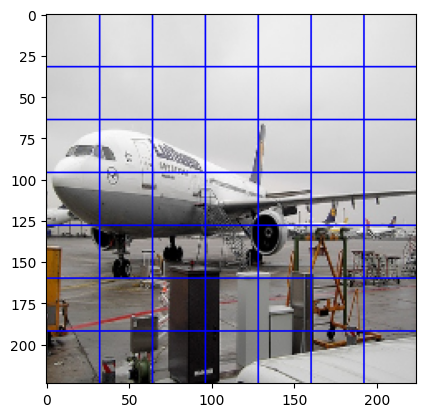

In [19]:
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

def draw_grid(img, grid_size):
    h, w = img.shape[:2]
    dx, dy = grid_size
    for i in range(dy, h, dy):
        cv2.line(img, (0, i), (w, i), color=(255, 0, 0))
    for i in range(dx, w, dx):
        cv2.line(img, (i, 0), (i, h), color=(255, 0, 0))
    return img

patch_size = (32, 32)
image_with_grid = draw_grid(image_resized, patch_size)
plt.imshow(cv2.cvtColor(image_with_grid, cv2.COLOR_BGR2RGB))

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    patch_features = model.encode_patch(image)
    
    logits_per_image, logits_per_text = model(image, text)
    # probs = logits_per_image.softmax(dim=-1).cpu().numpy()

image_features = image_features / image_features.norm(dim=1, keepdim=True)
text_features = text_features / text_features.norm(dim=1, keepdim=True)
patch_features = patch_features / patch_features.norm(dim=2, keepdim=True)
logits = patch_features @ text_features.t() * 100

probs = torch.zeros_like(logits)
# for i in range(logits.shape[1]):
#     probs[:, i] = logits[:, i].softmax(dim=-1)

probs = logits.squeeze(-1).softmax(dim=-1)

print ()
# print (logits)
print (logits.squeeze(-1))
print ()
sorted_values, sorted_indices = torch.sort(logits.squeeze(-1), descending=True)
# print (logits_per_image)  # prints: [[0.9927937  0.00421068 0.00299572]]
# print (text_features.shape)
for i in range(len(sorted_indices[0])):
    print (f'{sorted_indices[0, i]}: {sorted_values[0, i]}')
sorted_values.shape

airplane


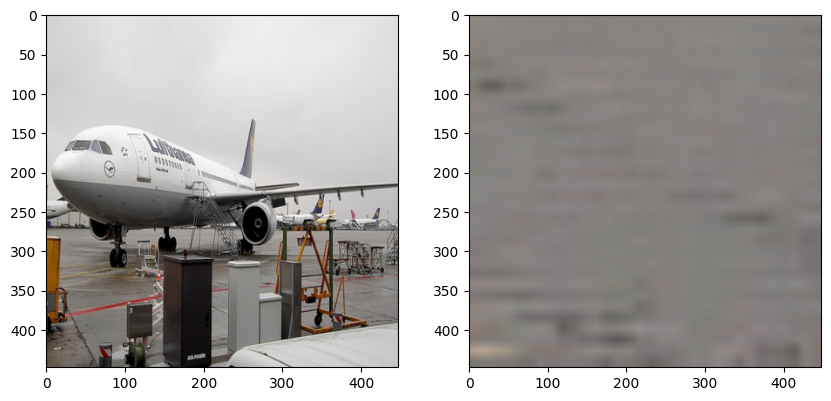

In [38]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((448, 448)),

])

img_path = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = torch.from_numpy(img)
# img = Image.open(img_path)
img = transform(img)

queries = ['<img>{}</img>What is the main object in this image? Response with only the name of it.'.format(img_path)]
# queries = ['test']
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
print (responses[0])

# plt.imshow(img.permute(1, 2, 0))
patches = img.unfold(1, 64, 64).unfold(2, 64, 64) # shape: (3, 32, 32, 14, 14)
patches = patches.contiguous().view(3, -1, 32, 32)
rp = patches[:, torch.randint(0, 196, (1, )).item()]
rp = T.Resize((448, 448))(rp)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img.permute(1, 2, 0))
axes[1].imshow(rp.permute(1, 2, 0))

In [39]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((448, 448)),

])

img_path = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = torch.from_numpy(img)
# img = Image.open(img_path)
img = transform(img) * 255

tpath = '/home/jy/mm/RVP/rvp/test_patches'
patches = img.unfold(1, 64, 64).unfold(2, 64, 64) # shape: (3, 32, 32, 14, 14)
patches = patches.contiguous().view(3, -1, 64, 64)
for i in range(patches.shape[1]):
    patch = patches[:, i]
    patch_img = T.Resize((448, 448))(patch)
    patch_img = patch_img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    patch_img = cv2.cvtColor(patch_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(tpath, "{}.jpg".format(i)), patch_img)

In [97]:
# img_path = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg'
# queries = ['<img>{}</img>Using the bottom left corner of the image as the origin, the horizontal axis is x and the vertical axis is y. \
# The coordinates of each pixel on the image are (x, y). \
# What is the object located at the image coordinates (250, 180)?'.format(img_path)]
queries = ['<img>{}</img>Using the bottom left corner of the image as the origin, what is the object located at the image coordinates (0, 0)?'.format(img_path)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
responses[0]

'<ref>0, 0</ref><box>(0,0),(999,999)</box>'

In [44]:
queries = ['How do you handle image coordinates?']
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
responses[0]

'When working with image coordinates, it\'s important to keep in mind that images are two-dimensional representations of the world, and the coordinates used to describe them are typically based on the pixel coordinates of the image. Here are some common ways to handle image coordinates:\n\n  1. Using the pixel coordinates: The most common way to handle image coordinates is to use the pixel coordinates of the image. These coordinates are typically represented as a tuple of integers, with the first coordinate representing the x-coordinate and the second coordinate representing the y-coordinate. For example, the pixel coordinates of the top-left corner of an image might be (0, 0).\n  2. Using the image size: Another way to handle image coordinates is to use the size of the image. In this case, the x-coordinate and y-coordinate are based on the width and height of the image, respectively. For example, the coordinates of the center of the image might be (width/2, height/2).\n  3. Using the 

In [4]:
img_path = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg'
prompt_template = '<img>{}</img> Describe this image.'
queries = [prompt_template.format(img_path)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
print (responses)

['The airport tarmac has several airplanes, including a large white and grey jet airliner from Lufthansa. The tarmac has multiple vehicles and equipment, and two sets of movable stairs are placed nearby the airplanes. One of the airplanes has a ladder placed against it, and there are a few people visible in the scene, likely working at the airport.']


重新处理特征聚类（先resize再聚类）

In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img.transpose(2, 0, 1))
H, W = img.shape[1], img.shape[2]

feature = feature_l['47'][:, 0].float().cuda()
feature = feature.contiguous().view(32, 32, 1664).permute(2, 0, 1)[None]
feature = F.interpolate(feature, (H, W), mode='bilinear').flatten(2).squeeze(0).permute(1, 0)
# num_clusters = 6
# kmeans = KMeans(n_clusters=num_clusters)
# cluster_ids = kmeans.fit_predict(feature.cpu().numpy())
dbscan = DBSCAN(eps=50, min_samples=500)
dbscan.fit(feature.cpu().numpy())
l = dbscan.labels_

print (feature.shape)
print (l.shape)
print (np.unique(l))
print (np.sum(l == 0))
print (feature)

In [ ]:
cluster_full_ids = torch.from_numpy(cluster_ids).cuda().contiguous().view(H, W)
masks = []
for id in torch.unique(cluster_full_ids):
    masks.append(cluster_full_ids == id)
masks = torch.stack(masks).cuda().byte()


color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)


structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

patch_size = H * W / (448 * 448) * 14 * 14

cnt = 0
for mask in masks:
    l, n = label(mask.cpu(), structure=structure)
    for lb in range(1, n + 1):
        if cnt == 3:
            print (f'l sum: {np.sum(lb == l)}')
        if np.sum(lb == l) <= 3 * patch_size:
            mask[lb == l] = 0

    reversed_mask = mask.logical_not()
    l, n = label(reversed_mask.cpu(), structure=structure)
    for lb in range(1, n + 1):
        if cnt == 3:
            print (f'rl sum: {np.sum(lb == l)}')
        if np.sum(lb == l) <= 10 * patch_size:
            mask[lb == l] = 1
    cnt += 1

# kernel_size = 8
# kernel = np.ones((kernel_size, kernel_size)).astype(np.uint8)
# for i in range(masks.shape[0]):
#     mask = masks[i].cpu().numpy()
#     mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
#     # mask = cv2.dilate(mask, kernel, iterations = 1)
#     # mask = cv2.erode(mask, kernel, iterations = 1)
#     masks[i] = torch.from_numpy(mask)

masks = masks[:, None].repeat(1, 3, 1, 1).to(torch.uint8)
img_repeated = img[None].expand_as(masks).cuda()

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[masks] = img_repeated[masks]
remain_imgs[masks.logical_not()] = img_repeated[masks.logical_not()]

# Render images
# Mix-up (Background brightness unchanged)
color_mode = 'G'
if color_mode == 'R':
    rendered_imgs = (mask_imgs * 0.6 + masks * Red * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Red * 0.4
elif color_mode == 'G':
    rendered_imgs = (mask_imgs * 0.6 + masks * Green * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Green * 0.4
elif color_mode == 'B':
    rendered_imgs = (mask_imgs * 0.6 + masks * Blue * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Blue * 0.4
else:
    raise ValueError('Color not supported: {}'.format(color_mode))

# fig, axes = plt.subplots(2, 3, figsize=(12, 6))
# # axes[0, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[0, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[0, 1].imshow(rendered_imgs[1].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[0, 2].imshow(rendered_imgs[2].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[1, 0].imshow(rendered_imgs[3].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[1, 1].imshow(rendered_imgs[4].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[1, 2].imshow(rendered_imgs[5].permute(1, 2, 0).cpu().to(torch.uint8))
plt.imshow(rendered_imgs[3].permute(1, 2, 0).cpu().to(torch.uint8))

In [ ]:
cluster_full_ids = torch.from_numpy(cluster_ids).cuda().contiguous().view(H, W)
masks = []
for id in torch.unique(cluster_full_ids):
    masks.append(cluster_full_ids == id)
masks = torch.stack(masks).cuda()


color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)


structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

for mask in masks:
    l, n = label(mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 3:
            mask[lb == l] = 0

    reversed_mask = mask.logical_not()
    l, n = label(reversed_mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 10:
            mask[lb == l] = 1
            
mask = masks[0]
mask = mask.cpu()


## 整理代码
空岛去除和空缺填补

In [ ]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l['10'][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

/home/jy/anaconda3/envs/mm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_19616/3376851694.py:76: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  mask_imgs[masks] = img_repeated[masks]


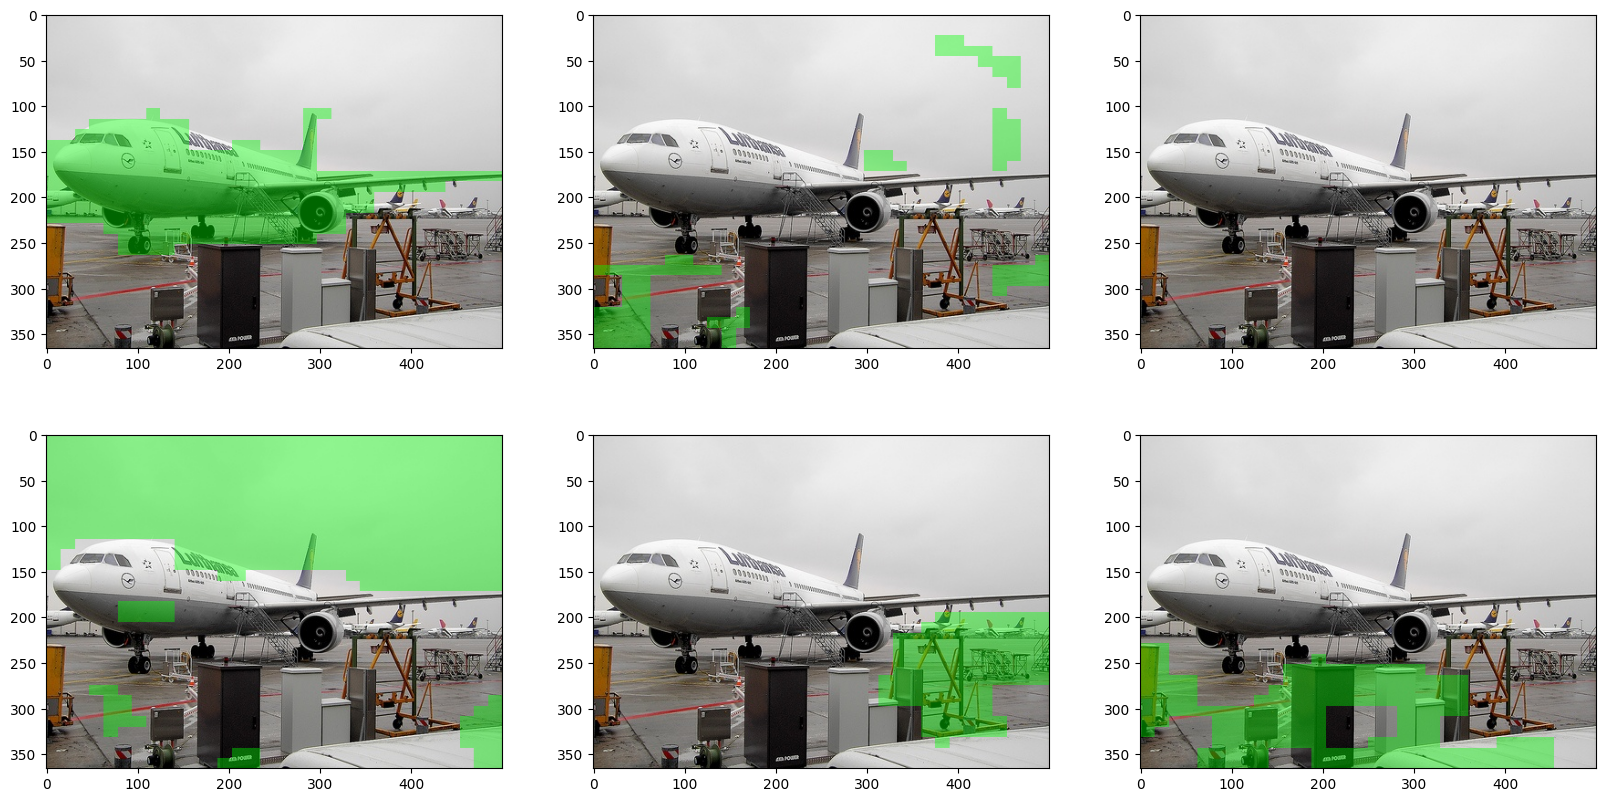

In [64]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l['47'][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

cluster_img = np.zeros((448, 448, 3))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img.transpose(2, 0, 1))
H, W = img.shape[1], img.shape[2]

# for i in range(32):
#     for j in range(32):
#         patch_label = cluster_ids[i * 32 + j]
#         # color = plt.cm.tab10(patch_label / 10)
#         # cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = color[:3]
#         cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = patch_label

# superpixels_masks.shape: (ids, C, H, W)
cluster_ids = np.resize(cluster_ids, (32, 32))
masks = []
for id in np.unique(cluster_ids):
    mask = (cluster_ids == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks).byte()

# 去除空岛和空缺
structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

for mask in masks:
    l, n = label(mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 3:
            mask[lb == l] = 0

    reversed_mask = mask.logical_not()
    l, n = label(reversed_mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 10:
            mask[lb == l] = 1
tmp_masks = masks.clone()

kernel_size = 3
kernel = np.ones((kernel_size, kernel_size)).astype(np.uint8)
for i in range(masks.shape[0]):
    mask = masks[i].cpu().numpy()
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # mask = cv2.dilate(mask, kernel, iterations = 1)
    # mask = cv2.erode(mask, kernel, iterations = 1)
    masks[i] = torch.from_numpy(mask)


masks = masks[:, None].repeat(1, 3, 1, 1).to(torch.uint8).cuda()
masks = TF.resize(masks, (H, W), interpolation=InterpolationMode.NEAREST)
tmp_masks = tmp_masks[:, None].repeat(1, 3, 1, 1).to(torch.uint8).cuda()
tmp_masks = TF.resize(tmp_masks, (H, W), interpolation=InterpolationMode.NEAREST)
img_repeated = img[None].expand_as(masks).cuda()



color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[masks] = img_repeated[masks]
remain_imgs[masks.logical_not()] = img_repeated[masks.logical_not()]

# Render images
# Mix-up (Background brightness unchanged)
color_mode = 'G'
if color_mode == 'R':
    rendered_imgs = (mask_imgs * 0.6 + masks * Red * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Red * 0.4
elif color_mode == 'G':
    rendered_imgs = (mask_imgs * 0.6 + masks * Green * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Green * 0.4
elif color_mode == 'B':
    rendered_imgs = (mask_imgs * 0.6 + masks * Blue * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Blue * 0.4
else:
    raise ValueError('Color not supported: {}'.format(color_mode))

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# axes[0, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
# axes[0, 0].imshow(masks[0, 0].cpu().numpy())
# axes[0, 1].imshow(masks[1, 0].cpu().numpy())
# axes[0, 2].imshow(masks[2, 0].cpu().numpy())
# axes[1, 0].imshow(masks[3, 0].cpu().numpy())
# axes[1, 1].imshow(masks[4, 0].cpu().numpy())
# axes[1, 2].imshow(masks[5, 0].cpu().numpy())
# axes[2, 0].imshow(tmp_masks[0, 0].cpu().numpy())
# axes[2, 1].imshow(tmp_masks[1, 0].cpu().numpy())
# axes[2, 2].imshow(tmp_masks[2, 0].cpu().numpy())
# axes[3, 0].imshow(tmp_masks[3, 0].cpu().numpy())
# axes[3, 1].imshow(tmp_masks[4, 0].cpu().numpy())
# axes[3, 2].imshow(tmp_masks[5, 0].cpu().numpy())
axes[0, 0].imshow(rendered_imgs[0].permute(1, 2, 0).cpu().to(torch.uint8))
axes[0, 1].imshow(rendered_imgs[1].permute(1, 2, 0).cpu().to(torch.uint8))
axes[0, 2].imshow(rendered_imgs[2].permute(1, 2, 0).cpu().to(torch.uint8))
axes[1, 0].imshow(rendered_imgs[3].permute(1, 2, 0).cpu().to(torch.uint8))
axes[1, 1].imshow(rendered_imgs[4].permute(1, 2, 0).cpu().to(torch.uint8))
axes[1, 2].imshow(rendered_imgs[5].permute(1, 2, 0).cpu().to(torch.uint8))

In [41]:
mask.shape

(32, 32)

In [44]:
cv2.dilate(mask.astype(np.uint8), kernel, iterations = 1)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

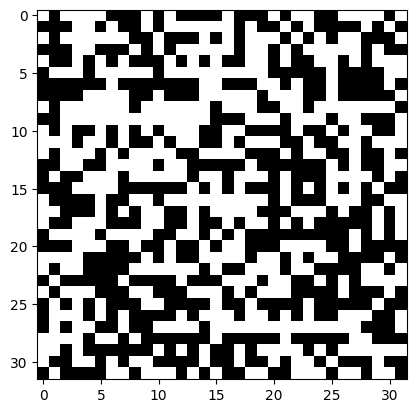

In [38]:
m = torch.randint(0, 2, size=(32, 32), dtype=torch.uint8)
plt.imshow(m[..., None], cmap='gray', interpolation='none')

## GT处理

### 导入config和val_datalodaer

In [2]:
class SimulateArgs:
    def __init__(self):
        self.config = '../mmsegmentation/my_configs/pascal_voc12_base.py'
        self.launcher = 'none'
        self.cfg_options = None
        self.work_dir = None
        self.checkpoint = None
        self.tta = False
        self.out = None

args = SimulateArgs()


# load config
cfg = Config.fromfile(args.config)
cfg.launcher = args.launcher
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = os.path.join('./work_dirs',
                            os.path.splitext(os.path.basename(args.config))[0])

cfg.load_from = args.checkpoint

# if args.show or args.show_dir:
#     cfg = trigger_visualization_hook(cfg, args)

if args.tta:
    cfg.test_dataloader.dataset.pipeline = cfg.tta_pipeline
    cfg.tta_model.module = cfg.model
    cfg.model = cfg.tta_model

# add output_dir in metric
if args.out is not None:
    cfg.test_evaluator['output_dir'] = args.out
    cfg.test_evaluator['keep_results'] = True

In [3]:
runner = Runner.from_cfg(cfg)
loader = runner.val_dataloader
evaluator = runner.val_evaluator

runner.call_hook('before_val')
runner.call_hook('before_val_epoch')
runner.model.eval()

# loader = iter(loader)
# for data_sample in loader:
#     img_path = data_sample['data_samples'][0].img_path
#     img_name = img_path.split('/')[-1].split('.')[0]
#     if img_name == '2008_006981':
#         break

12/17 13:32:58 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.18 (main, Sep 11 2023, 13:41:44) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 1791095845
    GPU 0,1,2,3,4,5,6,7: Tesla V100S-PCIE-32GB
    CUDA_HOME: /home/jy/apps/cuda-11.7
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arc

/home/jy/mm/RVP/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/17 13:33:03 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
12/17 13:33:03 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): _BatchNormXd(64, eps=

标准的gt单个样本render

In [71]:
gt_mask_dir = '/home/jy/mm/RVP/data/gt_masks'
for data_sample in loader:
    img_name = data_sample['data_samples'][0].img_path.split('/')[-1].split('.')[0]
    mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    mask[mask == 255] = 0
    np.save(os.path.join(gt_mask_dir, '{}.npy'.format(img_name)), mask.numpy())

In [72]:
from scipy.io import loadmat
basedir = '/home/jy/mm/tmp_data2/sbd/raw/benchmark_RELEASE/dataset/cls/'
savedir = '/home/jy/mm/RVP/data/gt_masks'
mask_names = sorted(os.listdir(basedir))
for mask_name in mask_names:
    mask_name = mask_name.split('.')[0]
    data = loadmat(os.path.join(basedir, mask_name))
    data = data['GTcls'][0][0][1][None]
    np.save(os.path.join(savedir, mask_name), data)

torch.Size([1, 483, 640])
tensor([  0, 255])


True

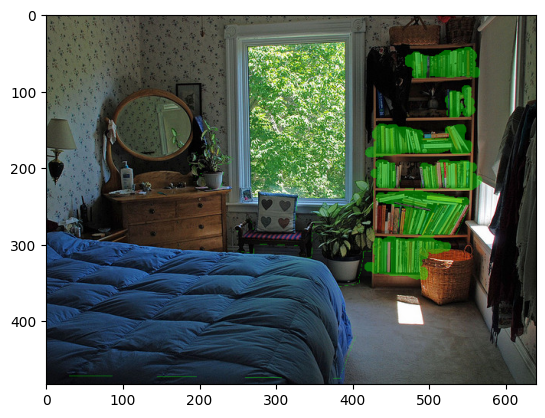

In [22]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]) # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img = cv2.imread(data_sample['data_samples'][0].img_path)
# img = cv2.imread('/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2008_000009.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img)[None].permute(0, 3, 1, 2)


mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
# mask = torch.from_numpy(data[None])
# mask = torch.from_numpy(np.load('/home/jy/mm/RVP/data/gt_masks/2008_000009.npy'))
print (mask.shape)
# mask[mask == 255] = 0
mask = torch.where((mask == 1) | (mask == 255), mask, 0)
mask = torch.where((mask == 255), mask, 0)
print (torch.unique(mask))
# plt.imshow(mask[0], cmap='gray', interpolation='none')
# mask[mask != 0] = 1
mask = mask[:, None].repeat(1, 3, 1, 1).bool()

mask_img = torch.zeros_like(img)
remain_img = torch.zeros_like(img)
mask_img[mask] = img[mask]
remain_img[mask.logical_not()] = img[mask.logical_not()]

# rendered_img = mask * Green * 0.4 + img * 0.6
rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
plt.imshow(rendered_img[0].permute(1, 2, 0).cpu().to(torch.uint8))

save_img = rendered_img[0].permute(1, 2, 0).cpu().to(torch.uint8)
save_img = save_img.numpy()
save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./air.png', save_img)

In [27]:
mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
torch.unique(mask)

tensor([  0,   1,   2,   4,   6,   9,  17, 255])

用point prompt在单个样本上构造，测试

torch.Size([1, 3, 483, 640])

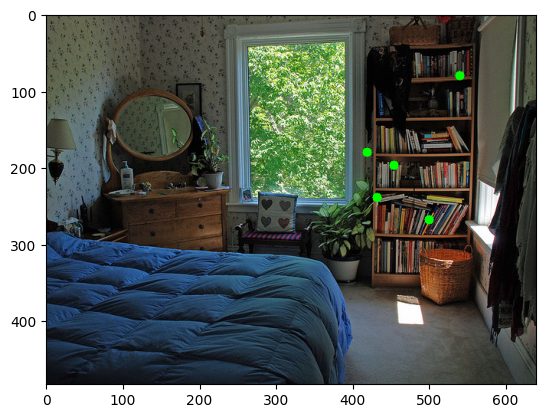

In [24]:
coords = torch.nonzero(mask)
n = min(5, coords.shape[0])
sampled_coords = coords[torch.randperm(coords.shape[0])[:n]]
pnt_img = img[0].clone().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
for _, _, y, x in sampled_coords:
    cv2.circle(pnt_img, (int(x), int(y)), 6, (0, 255, 0), -1)
plt.imshow(pnt_img)
mask.shape

img shape: torch.Size([1, 3, 366, 500])


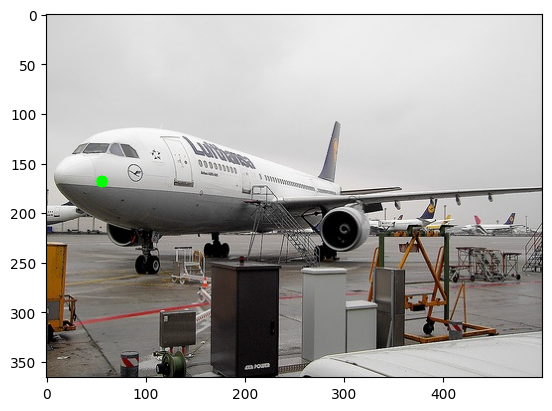

In [28]:
img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
print (f'img shape: {img.shape}')

mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
# 处理后的mask只有0和1
mask[mask == 255] = 0
mask[mask != 0] = 1
mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

# 计算质心的方法
_, _, H, W = mask.shape
y_coords = torch.arange(H)[None, None, :, None].expand_as(mask).cuda()
x_coords = torch.arange(W)[None, None, None, :].expand_as(mask).cuda()
y_weighted = mask * y_coords
x_weighted = mask * x_coords
y_center = y_weighted.sum(dim=(2, 3)) / torch.where(y_weighted != 0, 1, 0).sum(dim=(2, 3))
x_center = x_weighted.sum(dim=(2, 3)) / torch.where(x_weighted != 0, 1, 0).sum(dim=(2, 3))

rendered_img = img[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
# cv2.circle(rendered_img, (int(np.round(x_center[0][0].item())), int(np.round(y_center[0][0].item()))), 6, (0, 255, 0), -1)
coords = torch.nonzero(mask)
rand_coords = coords[torch.randint(0, len(coords), (1, ))][0]
ry, rx = rand_coords[2], rand_coords[3]
cv2.circle(rendered_img, (rx.item(), ry.item()), 6, (0, 255, 0), -1)
plt.imshow(rendered_img)

In [29]:
im = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./pair.png', im)

True

### GT数据集伪造

#### 处理数据集并保存

添加随机噪声

In [ ]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
os.makedirs('../data/voc_gt_modified', exist_ok=True)
for data_sample in loader:
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    resized_mask = TF.resize(gt_mask, (448, 448), interpolation=InterpolationMode.NEAREST)
    # resized_mask[(resized_mask < 255) & (resized_mask != 0)] = 1
    resized_mask[resized_mask == 255] = 0
    print (torch.unique(resized_mask))

    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
    
    save_dir_name = os.path.join('../data/voc_gt_modified', img_name)
    os.makedirs(save_dir_name, exist_ok=True)

    ## 按标签存
    for l in torch.unique(resized_mask):
        if (l == 0):
            continue
        label = l.item()
        
        ptr = torch.zeros(32, 32, dtype=torch.bool)
        ptr_mask = torch.rand(32, 32) < 0.06
        for i in range(32):
            for j in range(32):
                lbl = torch.unique(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14])
                if torch.any(lbl == label): 
                    ptr[i, j] = True
        ptr[ptr_mask] ^= True

        mask = TF.resize(ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
        mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

        mask_img = torch.zeros_like(img).cuda()
        remain_img = torch.zeros_like(img).cuda()
        mask_img[mask] = img[mask]
        remain_img[mask.logical_not()] = img[mask.logical_not()]

        # rendered_img = mask * Green * 0.4 + img * 0.6
        rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
        rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
        rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(os.path.join(save_dir_name, str(label)+'.jpg'), rendered_img)


更细粒度的在gt上添加噪声

In [ ]:
def add_squares(mask, num_squares, square_size):
    """
    背景区域（mask中为0的区域）添加1的方块
    Args:
        mask (_type_): _description_
        num_squares (_type_): _description_
        square_size (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask = mask.clone().numpy().astype(np.uint8)
    coords = np.column_stack(np.nonzero(mask == 0))
    mask = np.zeros_like(mask).astype(np.uint8)
    rows, cols = mask.shape
    rand_ids = torch.randperm(len(coords))[:num_squares]
    
    for idx in rand_ids:
        # x, y = np.random.randint(cols - square_size), np.random.randint(rows - square_size)
        # rand_idx = np.random.randint(0, len(coords) - 1)
        y, x = coords[idx]
        y, x = min(rows - square_size, y), min(cols - square_size, x)
        if mask[y, x] == 0:  # 只在背景区域添加方块
            cv2.rectangle(mask, (x, y), (x + square_size, y + square_size), (1, ), thickness=-1)
    return torch.from_numpy(mask)

def remove_squares(mask, num_squares, square_size):
    """
    前景区域（mask中为1的区域）添加0的方块
    Args:
        mask (_type_): _description_
        num_squares (_type_): _description_
        square_size (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask = mask.clone().numpy().astype(np.uint8)
    coords = np.column_stack(np.nonzero(mask == 1))
    rows, cols = mask.shape
    rand_ids = torch.randperm(len(coords))[:num_squares]

    for idx in rand_ids:
        # x, y = np.random.randint(cols - square_size), np.random.randint(rows - square_size)
        # rand_idx = np.random.randint(0, len(coords) - 1)
        y, x = coords[idx]
        y, x = min(rows - square_size, y), min(cols - square_size, x)
        if mask[y, x] == 1:  # 只在前景区域移除方块
            cv2.rectangle(mask, (x, y), (x + square_size, y + square_size), (0, ), thickness=-1)
    return torch.from_numpy(mask)

color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
os.makedirs('../data/voc_gt_modified', exist_ok=True)

for data_sample in loader:
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    resized_mask = TF.resize(gt_mask, (448, 448), interpolation=InterpolationMode.NEAREST)
    # resized_mask[(resized_mask < 255) & (resized_mask != 0)] = 1
    resized_mask[resized_mask == 255] = 0

    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()

    save_dir_name = os.path.join('../data/voc_gt_modified', img_name)
    os.makedirs(save_dir_name, exist_ok=True)

    ## 按标签存
    for l in torch.unique(resized_mask):
        if (l == 0):
            continue
        label = l.item()
        
        ptr = torch.zeros(32, 32, dtype=torch.bool)
        for i in range(32):
            for j in range(32):
                lbl = torch.unique(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14])
                if torch.any(lbl == label): 
                    ptr[i, j] = True
        tmp_ptr = ptr.to(torch.uint8)
        # ptr_mask = torch.rand(32, 32) < 0.06
        # ptr[ptr_mask] ^= True
        ptr_1_sum = torch.sum(ptr == 1).item()
        ptr_0_sum = torch.sum(ptr == 0).item()
        # ptr = add_squares(ptr, num_squares=np.floor(ptr_0_sum * 0.).astype(int), square_size=0)
        # ptr = remove_squares(ptr, num_squares=np.floor(ptr_1_sum * 100).astype(int), square_size=0)
        # ptr = add_squares(ptr, num_squares=20, square_size=0)
        ptr = add_squares(ptr, num_squares=np.floor(ptr_0_sum * 0.02).astype(int), square_size=2) | remove_squares(ptr, num_squares=np.floor(ptr_1_sum * 0.1).astype(int), square_size=1)
        
        mask = TF.resize(ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
        mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

        mask_img = torch.zeros_like(img).cuda()
        remain_img = torch.zeros_like(img).cuda()
        mask_img[mask] = img[mask]
        remain_img[mask.logical_not()] = img[mask.logical_not()]


        rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
        rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
        rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(os.path.join(save_dir_name, str(label)+'.jpg'), rendered_img)
    
    # 存背景
    ptr = torch.zeros(32, 32, dtype=torch.bool)
    for i in range(32):
        for j in range(32):
            if torch.any(resized_mask[0, i*14:(i+1)*14, j*14:(j+1)*14] != 0): 
                ptr[i, j] = True
    reversed_ptr = ptr.logical_not().to(torch.uint8)
    removed_reversed_ptr = remove_squares(reversed_ptr, num_squares=np.floor(torch.sum(reversed_ptr == 1).item() * 0.2).astype(int), square_size=1)
    added_reversed_ptr = add_squares(reversed_ptr, num_squares=np.floor(torch.sum(reversed_ptr == 0.2).item() * 0.1).astype(int), square_size=2)
    reversed_ptr = added_reversed_ptr | removed_reversed_ptr
    
    mask = TF.resize(reversed_ptr[None], (gt_mask.shape[1], gt_mask.shape[2]), interpolation=InterpolationMode.NEAREST)
    mask = mask[:, None].repeat(1, 3, 1, 1).bool().cuda()

    mask_img = torch.zeros_like(img).cuda()
    remain_img = torch.zeros_like(img).cuda()
    mask_img[mask] = img[mask]
    remain_img[mask.logical_not()] = img[mask.logical_not()]

    rendered_img = (mask_img * 0.6 + mask * Green * 0.4) + remain_img
    rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
    rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(os.path.join(save_dir_name, '0.jpg'), rendered_img)
    

# plt.imshow(rendered_img)
# fig, axes = plt.subplots(1, 2, figsize=(5, 10))
# axes[0].imshow(tmp_ptr, cmap='gray', interpolation='none')
# axes[1].imshow(ptr, cmap='gray', interpolation='none')

在gt上构造point prompt数据集

SBD训练集

In [101]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

names = []
with open('/home/jy/mm/RVP/data/VOCdevkit/VOC2012/ImageSets/Segmentation/trainaug.txt', 'r') as file:
    for line in file:
        names.append(line.replace('\n', ''))

maskdir = '/home/jy/mm/RVP/data/gt_masks'
imgdir = '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages'
mask_names = sorted(os.listdir(maskdir))
os.makedirs('../data/voc_gt_modified', exist_ok=True)
for name in names:
    mask = torch.from_numpy(np.load(os.path.join(maskdir, '{}.npy'.format(name)))).cuda()
    img = cv2.imread(os.path.join(imgdir, '{}.jpg'.format(name)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()
    
    savedir = os.path.join('../data/voc_gt_modified/', name)
    os.makedirs(savedir, exist_ok=True)
    
    for l in torch.unique(mask):
        l = l.item()
        class_mask = (mask == l).cuda().byte()
        coords = torch.nonzero(class_mask)
        rand_coords = coords[torch.randint(2, len(coords), (1, ))]
        
        for i in range(rand_coords.shape[0]):
            ry, rx = rand_coords[i, 1], rand_coords[i, 2]
            
            # rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
            rendered_img = img.clone()[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            cv2.circle(rendered_img, (rx.item(), ry.item()), 6, (0, 255, 0), -1)
            rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(savedir, '{}_{}.jpg'.format(l, i)), rendered_img)

In [105]:
len(os.listdir('/home/jy/mm/RVP/data/voc_gt_modified'))

10582

### 存储各个数据集的基础数据

In [4]:
dataset_gt_dirs = {
    'ade20k'     : '/home/jy/mm/RVP/data/datasets/ade20k/voc_gt_modified',
    'cityscapes' : '/home/jy/mm/RVP/data/datasets/cityscapes/voc_gt_modified',
    'cocostuff'  : '/home/jy/mm/RVP/data/datasets/coco_stuff164k/voc_gt_modified',
    'context'    : '/home/jy/mm/RVP/data/datasets/context/voc_gt_modified',
    'voc'        : '/home/jy/mm/RVP/data/datasets/VOCdevkit/voc_gt_modified',
}

color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]).cuda() # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_name = []
dataset_dir = '/home/jy/mm/RVP/data/datasets/VOCdevkit/'
os.makedirs(os.path.join(dataset_dir, 'voc_gt_modified'), exist_ok=True)

for data_sample in loader:
    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img)[None].permute(0, 3, 1, 2).cuda()

    mask = data_sample['data_samples'][0].gt_sem_seg.data.clone().cuda()
    mask[mask == 255] = 0
    
    save_dir_name = os.path.join(os.path.join(dataset_dir, 'voc_gt_modified'), img_name)
    os.makedirs(save_dir_name, exist_ok=True)
    print (img_name)
    ## 按标签存
    for l in torch.unique(mask):
        print (l)
        l = l.item()
        class_mask = (mask == l).cuda().to(torch.uint8)
        coords = torch.nonzero(class_mask)
        if len(coords) <= 1:
            continue
        rand_coords = coords[torch.randint(1, len(coords), (1, ))]
        for i in range(rand_coords.shape[0]):
            ry, rx = rand_coords[i, 1], rand_coords[i, 2]
            
            # rendered_img = rendered_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)
            rendered_img = img.clone()[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            cv2.circle(rendered_img, (rx.item(), ry.item()), 6, (0, 255, 0), -1)
            rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(save_dir_name, '{}_{}.jpg'.format(l, i)), rendered_img)

2007_000032
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(15, device='cuda:0')
2007_000039
tensor(0, device='cuda:0')
tensor(20, device='cuda:0')
2007_000063
tensor(0, device='cuda:0')
tensor(9, device='cuda:0')
tensor(12, device='cuda:0')
2007_000068
tensor(0, device='cuda:0')
tensor(3, device='cuda:0')
2007_000121
tensor(0, device='cuda:0')
tensor(20, device='cuda:0')
2007_000170
tensor(0, device='cuda:0')
tensor(5, device='cuda:0')
tensor(15, device='cuda:0')
2007_000241
tensor(0, device='cuda:0')
tensor(4, device='cuda:0')
2007_000243
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
2007_000250
tensor(0, device='cuda:0')
tensor(5, device='cuda:0')
tensor(11, device='cuda:0')
2007_000256
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
2007_000333
tensor(0, device='cuda:0')
tensor(19, device='cuda:0')
2007_000363
tensor(0, device='cuda:0')
tensor(3, device='cuda:0')
2007_000364
tensor(0, device='cuda:0')
tensor(14, device='cuda:0')
tensor(15, device='cuda:0'

In [8]:
print (len(os.listdir('/home/jy/mm/RVP/data/datasets/ade20k/voc_gt_modified')))
len(os.listdir('/home/jy/mm/RVP/data/datasets/ade20k/ADEChallengeData2016/images/training'))

20210


20210

#### 构造json文件

In [5]:
classes = {
    'ade20k' : (
        'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road',
        'bed ', 'windowpane', 'grass', 'cabinet', 'sidewalk',
        'person', 'earth', 'door', 'table', 'mountain', 'plant',
        'curtain', 'chair', 'car', 'water', 'painting', 'sofa',
        'shelf', 'house', 'sea', 'mirror', 'rug', 'field', 'armchair',
        'seat', 'fence', 'desk', 'rock', 'wardrobe', 'lamp',
        'bathtub', 'railing', 'cushion', 'base', 'box', 'column',
        'signboard', 'chest of drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'grandstand',
        'path', 'stairs', 'runway', 'case', 'pool table', 'pillow',
        'screen door', 'stairway', 'river', 'bridge', 'bookcase',
        'blind', 'coffee table', 'toilet', 'flower', 'book', 'hill',
        'bench', 'countertop', 'stove', 'palm', 'kitchen island',
        'computer', 'swivel chair', 'boat', 'bar', 'arcade machine',
        'hovel', 'bus', 'towel', 'light', 'truck', 'tower',
        'chandelier', 'awning', 'streetlight', 'booth',
        'television receiver', 'airplane', 'dirt track', 'apparel',
        'pole', 'land', 'bannister', 'escalator', 'ottoman', 'bottle',
        'buffet', 'poster', 'stage', 'van', 'ship', 'fountain',
        'conveyer belt', 'canopy', 'washer', 'plaything',
        'swimming pool', 'stool', 'barrel', 'basket', 'waterfall',
        'tent', 'bag', 'minibike', 'cradle', 'oven', 'ball', 'food',
        'step', 'tank', 'trade name', 'microwave', 'pot', 'animal',
        'bicycle', 'lake', 'dishwasher', 'screen', 'blanket',
        'sculpture', 'hood', 'sconce', 'vase', 'traffic light',
        'tray', 'ashcan', 'fan', 'pier', 'crt screen', 'plate',
        'monitor', 'bulletin board', 'shower', 'radiator', 'glass',
        'clock', 'flag'
    ),

    'cityscapes' : (
        'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
        'traffic light', 'traffic sign', 'vegetation', 'terrain',
        'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
        'motorcycle', 'bicycle'
    ),
    
    'cocostuff' : (
        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
        'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
        'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
        'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
        'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
        'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
        'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
        'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
        'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner',
        'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet',
        'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile',
        'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain',
        'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble',
        'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower',
        'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel',
        'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal',
        'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net',
        'paper', 'pavement', 'pillow', 'plant-other', 'plastic',
        'platform', 'playingfield', 'railing', 'railroad', 'river', 'road',
        'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf',
        'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs',
        'stone', 'straw', 'structural-other', 'table', 'tent',
        'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick',
        'wall-concrete', 'wall-other', 'wall-panel', 'wall-stone',
        'wall-tile', 'wall-wood', 'water-other', 'waterdrops',
        'window-blind', 'window-other', 'wood'
    ),

    'context' : (
        'background', 'aeroplane', 'bag', 'bed', 'bedclothes',
        'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle',
        'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling',
        'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog',
        'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground',
        'horse', 'keyboard', 'light', 'motorbike', 'mountain',
        'mouse', 'person', 'plate', 'platform', 'pottedplant', 'road',
        'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow',
        'sofa', 'table', 'track', 'train', 'tree', 'truck',
        'tvmonitor', 'wall', 'water', 'window', 'wood'
    ),

    'voc' : (
        'background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
        'sofa', 'train', 'tvmonitor'
    ),
    # voc_classes = (
    #     'background', 'aeroplane', 'bicycle', 'bird', 'boat',
    #     'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    #     'dog', 'horse', 'motorbike', 'person'
    # )
}

def convert_labels(classes):
    classes_str = ""
    for name in classes:
        classes_str += (name + ", ")
    classes_str = classes_str[:-2]

    name2id, id2name = dict(), dict()

    for id, class_name in enumerate(classes):
        name2id[class_name] = id
        id2name[id] = class_name
        
    return classes_str, name2id, id2name

构造选择的样本txt文件

In [6]:
dataset_gt_dirs = {
    'ade20k'     : '/home/jy/mm/RVP/data/datasets/ade20k/voc_gt_modified',
    'cityscapes' : '/home/jy/mm/RVP/data/datasets/cityscapes/voc_gt_modified',
    'cocostuff'  : '/home/jy/mm/RVP/data/datasets/coco_stuff164k/voc_gt_modified',
    'context'    : '/home/jy/mm/RVP/data/datasets/context/voc_gt_modified',
    'voc'        : '/home/jy/mm/RVP/data/datasets/VOCdevkit/voc_gt_modified',
}

json_list = []
for dataset_name in dataset_gt_dirs.keys():
    dataset_gt_dir = dataset_gt_dirs[dataset_name]
    _, _, dataset_id2names = convert_labels(classes[dataset_name])
    
    img_names = os.listdir(dataset_gt_dir)
    img_names = sorted(img_names)

    rand_idx = torch.randperm(len(img_names))[:200]
    img_names = [img_names[i] for i in rand_idx]

    data_list = []
    for img_name in img_names:
        img_dir           = os.path.join(dataset_gt_dir, img_name)
        labeled_img_names = os.listdir(img_dir)
        
        rand_idx          = torch.randperm(len(labeled_img_names))[:1]
        labeled_img_names = [labeled_img_names[i] for i in rand_idx]
        
        dic = {
            "img_name" : "{}".format(img_name),
            "img_dir" : "{}".format(img_dir),
            "labeled_img_names": labeled_img_names
        }
        
        data_list.append(dic)
    json_list.append({dataset_name: data_list})
        
with open('save.json', 'w') as file:
    json.dump(json_list, file, indent=4)


In [104]:
# prompt_template = '<img>{}</img> \
# What is the most likely category of the object under the green glow? \
# Choose your answer from this list: {}.'
prompt_template = '<img>{}</img> \
What is the most likely category of the object marked by the green dot? \
Choose your answer from this list: {}.'
json_list = []
basedir = '/home/jy/mm/RVP/data/voc_gt_modified'
imgdirs = os.listdir(basedir)
cnt = 0
for img_name in imgdirs:
    imgdir = os.path.join(basedir, img_name)
    img_names = os.listdir(imgdir)
    ids = np.array([int(x.split('.')[0].split('_')[0]) for x in img_names])
    if np.any(ids > 15):
        continue
    
    for img_name in img_names:
        id = int(img_name.split('.')[0].split('_')[0])
        
        img_path = os.path.join(imgdir, img_name)
        dic = {
            "id": "identity_{}".format(cnt),
            "conversations": [
                {
                    "from": "user",
                    "value": prompt_template.format(img_path, classes_str)
                },
                {
                    "from": "assistant",
                    "value": "{}".format(id2name[id])
                }
            ]
        }
        cnt += 1
        json_list.append(dic)

with open('data.json', 'w') as file:
    json.dump(json_list, file, indent=4)

多数据集融合

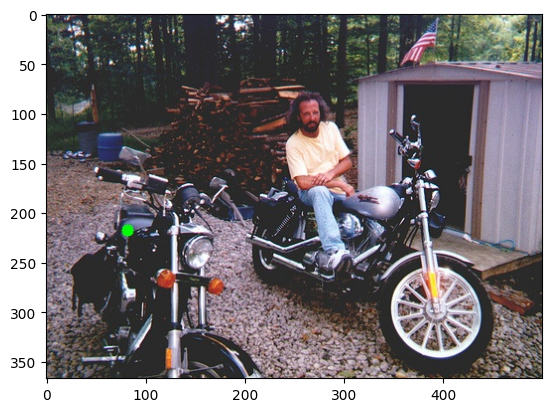

In [10]:
im = cv2.imread('/home/jy/mm/RVP/data/datasets/VOCdevkit/voc_gt_modified/2011_003078/14_0.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [7]:
prompt_template = '<img>{}</img> \
What is the most likely category of the object marked by the green dot?'

data_jsonfile = '/home/jy/mm/RVP/rvp/save.json'
with open(data_jsonfile, 'r') as file:
    full_data_json = json.load(file)

json_list = []
cnt = 0
for dataset in full_data_json:
    for dataset_name in dataset.keys():
        datas = dataset[dataset_name]
        _, _, dataset_id2names = convert_labels(classes[dataset_name])
        for data in datas:
            img_name          = data['img_name']
            img_dir           = data['img_dir']
            labeled_img_names = data['labeled_img_names']
            for labeled_img_name in labeled_img_names:
                id               = int(labeled_img_name.split('.')[0].split('_')[0])
                labeled_img_path = os.path.join(img_dir, labeled_img_name)
                
                dic = {
                    "id": "identity_{}".format(cnt),
                    "conversations": [
                        {
                            "from": "user",
                            "value": prompt_template.format(labeled_img_path)
                        },
                        {
                            "from": "assistant",
                            "value": "{}".format(dataset_id2names[id])
                        }
                    ]
                }
                cnt += 1
                json_list.append(dic)

with open('data.json', 'w') as file:
    json.dump(json_list, file, indent=4)

### 展示GT数据

In [ ]:
data_sample = next(val_dataloader)
img = cv2.imread(data_sample['data_samples'][0].img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
print (torch.unique(mask))
# mask[(mask < 255) & (mask != 0)] = 1
print (torch.unique(mask))
print (mask.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[1].imshow(mask[0], cmap='gray', interpolation='none')


## 获取CC12M数据集数据

In [ ]:
# 使用pandas读取TSV文件
data = pd.read_csv('../data/cc12m.tsv', sep='\t', header=None)

In [ ]:
random_data = data.sample(n=2000, random_state=1234)
random_data.iloc[0][0]
random_data.columns = ['website', 'caption']

In [ ]:
data = pd.read_csv('cc12.csv')
if not os.path.exists('../data/cc12'):
    os.makedirs('../data/cc12')

failed_list = []
for idx, row in data.iterrows():
    url = row['website']
    print (f'{idx}: {url}')
    
    try:
        img_response = urllib.request.urlopen(url)
        img_array = np.array(bytearray(img_response.read()), dtype=np.uint8)
        img = cv2.imdecode(img_array, -1)
        
        file_path = os.path.join('../data/cc12', '{}.jpg'.format(idx))
        cv2.imwrite(file_path, img)
    except:
        failed_list.append(idx)
print (failed_list)

# 计算指标

point prompt预测准确率

In [38]:
total = 0
right = 0
for data_sample in loader:
    img_path = data_sample['data_samples'][0].img_path
    img_name = img_path.split('/')[-1].split('.')[0]
    gt_mask = data_sample['data_samples'][0].gt_sem_seg.data.clone()
    pred = np.load(os.path.join('../data/sem_seg_preds/scikit30/G/', '{}.npy'.format(img_name)))
    pred = torch.from_numpy(pred)
    total += torch.nonzero(pred).shape[0]
    for pos in zip(*torch.nonzero(pred, as_tuple=True)):
        if (pred[pos] == 255):
            pred[pos] = 0
        if (pred[pos] == gt_mask[pos]):
            right += 1

print (right / total)

0.7691879866518354


In [10]:
len(os.listdir('/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages'))

17125